In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import quantumsolver as qs

# help(qs.fewnucleonEmulator)

# Vectorized version of the fewnucleonEmulator
vfewnucleonEmulator = np.vectorize(qs.fewnucleonEmulator)


In [119]:
# LaTeX font
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
font_size = 12

cD_grid = np.linspace(-2.5, 2.5, 1000)
cE_grid = np.linspace(-1., 1., 1000)

# Create a 2-dimensional grid
cD_eval, cE_eval = np.meshgrid(cD_grid,cE_grid)


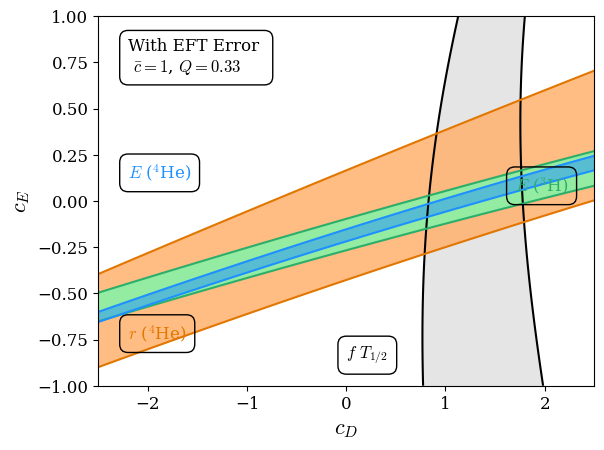

In [120]:

def constraint_plotter(cD_eval, cE_eval, efterror=False):

    E4He_eval, Rp4He_eval, _, E3He_eval, E3H_eval, _, fT3H_eval = vfewnucleonEmulator(cD_eval, cE_eval)
            
    fig, ax = plt.subplots()

    x = 1

    mean_E4He = -28.296 # np.mean(E4He_eval)
    mean_Rp4He = 1.4552  # np.mean(Rp4He_eval)
    mean_E3H = -8.482 # np.mean(E3H_eval) 
    mean_fT3H = 1129.6 #np.mean(fT3H_eval)

    sigma_E3H = 0.015
    sigma_E4He = 0.005
    sigma_Rp4He = 0.0062
    sigma_fT3H = 3.

    if efterror:
        sigma_E3H = np.sqrt(0.015 + (1 * 0.33**4 * -8.482)**2/(1 - 0.33**2))
        sigma_E4He = np.sqrt(0.005 + (1 * 0.33**4 * -28.296)**2/(1 - 0.33**2))
        sigma_Rp4He = np.sqrt(0.0062 + (1 * 0.33**4 * 1.4552)**2/(1 - 0.33**2))
        sigma_fT3H = np.sqrt(3. + (1 * 0.33**4 * 1129.6)**2/(1 - 0.33**2))
        ax.text(-2.2, 0.7, 'With EFT Error \n $\\bar{c}=1$, $Q=0.33$', color='black', 
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.5'), fontsize=font_size)
    else:
        ax.text(-2.2, 0.78, 'No EFT Error', color='black', 
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.5'), fontsize=font_size)

    cs= ax.contourf(cD_eval, cE_eval, fT3H_eval, levels=[mean_fT3H-x*sigma_fT3H, mean_fT3H+x*sigma_fT3H], colors='gray', alpha=0.2)
    contour_lines = ax.contour(cs, levels=cs.levels[:3], colors='black')
    cs = ax.contourf(cD_eval, cE_eval, Rp4He_eval, levels=[mean_Rp4He-x*sigma_Rp4He, mean_Rp4He+x*sigma_Rp4He], colors='#ffb16d', alpha=0.85)
    contour_lines = ax.contour(cs, levels=cs.levels[:3], colors='#e17701')
    cs = ax.contourf(cD_eval, cE_eval, E3H_eval, levels=[mean_E3H-x*sigma_E3H, mean_E3H+x*sigma_E3H], colors='#7af9ab', alpha=0.8)
    contour_lines = ax.contour(cs, levels=cs.levels[:3], colors='#2baf6a', linestyles='-')
    cs = ax.contourf(cD_eval, cE_eval, E4He_eval, levels=[mean_E4He-x*sigma_E4He, mean_E4He+x*sigma_E4He], colors='dodgerblue', alpha=0.5)
    contour_lines = ax.contour(cs, levels=cs.levels[:3], colors='dodgerblue', linestyles='-')

    return ax

def customizer(ax):

    ax.set_xlabel('$c_D$', fontsize=font_size+4)
    ax.set_ylabel('$c_E$', fontsize=font_size+4)
    ax.text(0., -0.85, '$f$ $T_{1/2}$', color='black', 
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.5'), fontsize=font_size)
    ax.text(-2.2, -0.75, '$r$ ($^4$He)', color='#e17701', 
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.5'), fontsize=font_size)
    ax.text(1.7, 0.05, '$E$ ($^3$H)', color='#2baf6a', 
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.5'), fontsize=font_size)
    ax.text(-2.2, 0.12, '$E$ ($^4$He)', color='dodgerblue', 
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.5'), fontsize=font_size)
    ax.tick_params(axis='x', labelsize=font_size)
    ax.tick_params(axis='y', labelsize=font_size)

save = False
efterror = True

### Comment after one use for customization of text boxes by changing
### the customizer function
ax = constraint_plotter(cD_eval, cE_eval, efterror=efterror)

for txt in ax.texts[1:]:
    txt.set_visible(False)
    ax.texts[1:].remove(txt)

customizer(ax)

fig = ax.get_figure()
if efterror and save:
    fig.savefig('figs/constraints_EFT.pdf', bbox_inches='tight')
elif save:
    fig.savefig('figs/constraints_noEFT.pdf', bbox_inches='tight')


In [69]:
import emcee
import scipy.stats as stats
import corner

sigma_E3H = np.sqrt(0.015 + (1 * 0.33**4 * -8.482)**2/(1 - 0.33**2))
sigma_E4He = np.sqrt(0.005 + (1 * 0.33**4 * -28.296)**2/(1 - 0.33**2))
sigma_Rp4He = np.sqrt(0.0062 + (1 * 0.33**4 * 1.4552)**2/(1 - 0.33**2))
sigma_fT3H = np.sqrt(3. + (1 * 0.33**4 * 1129.6)**2/(1 - 0.33**2))

def log_prior(params):
    
    cD, cE = params
    cD_mu = 0.
    cD_sigma = 5
    cE_mu = 0.
    cE_sigma = 5

    return (stats.norm.logpdf(cD, loc=cD_mu, scale=cD_sigma) + 
            stats.norm.logpdf(cE, loc=cE_mu, scale=cE_sigma))   

def log_likelihood(params, data_set):
    cD, cE = params
    E4He, Rp4He, _, _, E3H, _, fT3H = vfewnucleonEmulator(cD, cE)

    # mean_E4He = np.mean(E4He) # -28.296
    # mean_Rp4He = np.mean(Rp4He) # 1.4552
    # mean_E3H = np.mean(E3H) # -8.482
    # mean_fT3H = np.mean(fT3H) # 1129.6

    if len(data_set) == 2:
        return (np.sum(stats.norm.logpdf(E4He, mean_E4He, sigma_E4He)) + 
                np.sum(stats.norm.logpdf(Rp4He, mean_Rp4He, sigma_Rp4He)))
    elif len(data_set) == 4:
        return (np.sum(stats.norm.logpdf(E4He, -28.296, sigma_E4He)) +
                np.sum(stats.norm.logpdf(Rp4He, 1.4552, sigma_Rp4He)) +
                np.sum(stats.norm.logpdf(E3H, -8.482, sigma_E3H)) +
                np.sum(stats.norm.logpdf(fT3H, 1129.6, sigma_fT3H)))

def log_posterior(params, data_set):
    return log_prior(params) + log_likelihood(params, data_set)

cD = np.random.normal(0., 5, 50)
cE = np.random.normal(0., 5, 50)

pos = np.vstack((cD, cE))

nwalkers, ndim = pos.T.shape

E4He, Rp4He, _, _, E3H, _, fT3H = vfewnucleonEmulator(cD, cE)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_fn=log_posterior, args=[(E4He, Rp4He, E3H, fT3H)])
burn = sampler.run_mcmc(pos.T, 10000, progress=True)


100%|██████████| 10000/10000 [12:36<00:00, 13.23it/s]


[[ 0.82744426 -0.05865794]
 [ 1.29752517  0.02167178]
 [ 1.77130016  0.10154394]]


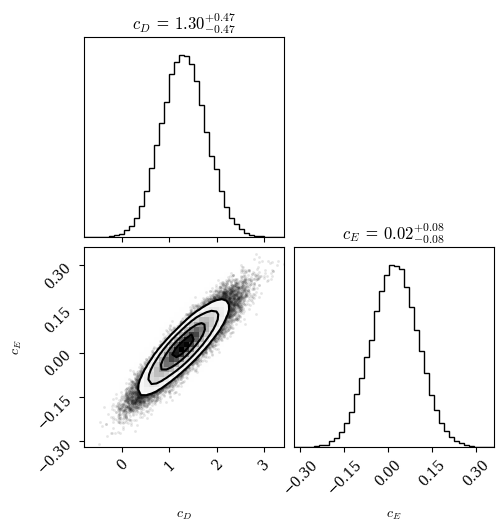

In [118]:
samples = sampler.get_chain(flat=True)
#plt.hist(samples[:, 1], 1000, color="k", histtype="step")
#plt.xlim(-1, 1)
#plt.show()

flat_samples = sampler.get_chain(discard=2000, thin=10, flat=True)
fig = corner.corner(flat_samples, labels=[r"$c_D$", r"$c_E$"], color='k',
                show_titles=True, bins=40, smooth=1.0)

values = np.percentile(flat_samples, [16, 50, 84], axis=0)
print(values)